# LRMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from utils import get_home_and_home_data

In [2]:
data = get_home_and_home_data([i for i in range(2000, 2004)], ot=False)

In [3]:
df = data.copy()
del df['pts_diff_away']

In [4]:
df_count = df.groupby(["pts_diff_home"]).count()

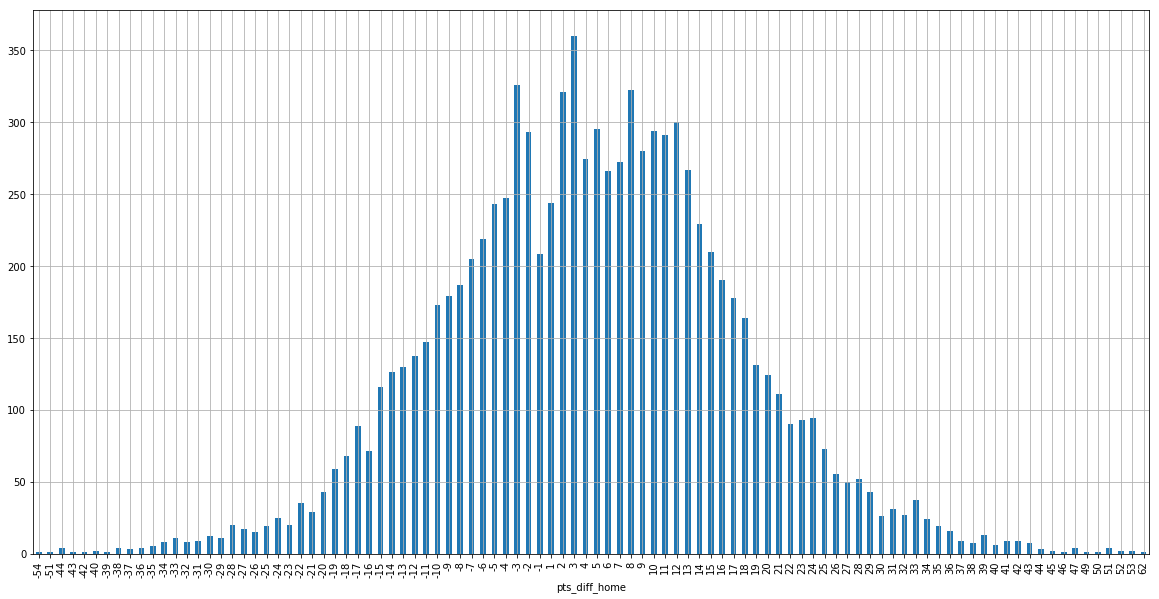

In [5]:
df_count.plot(kind='bar', figsize = (20, 10), grid=True, legend=False)
plt.show()

In [6]:
df_mean = df.groupby(["pts_diff_home"]).mean()

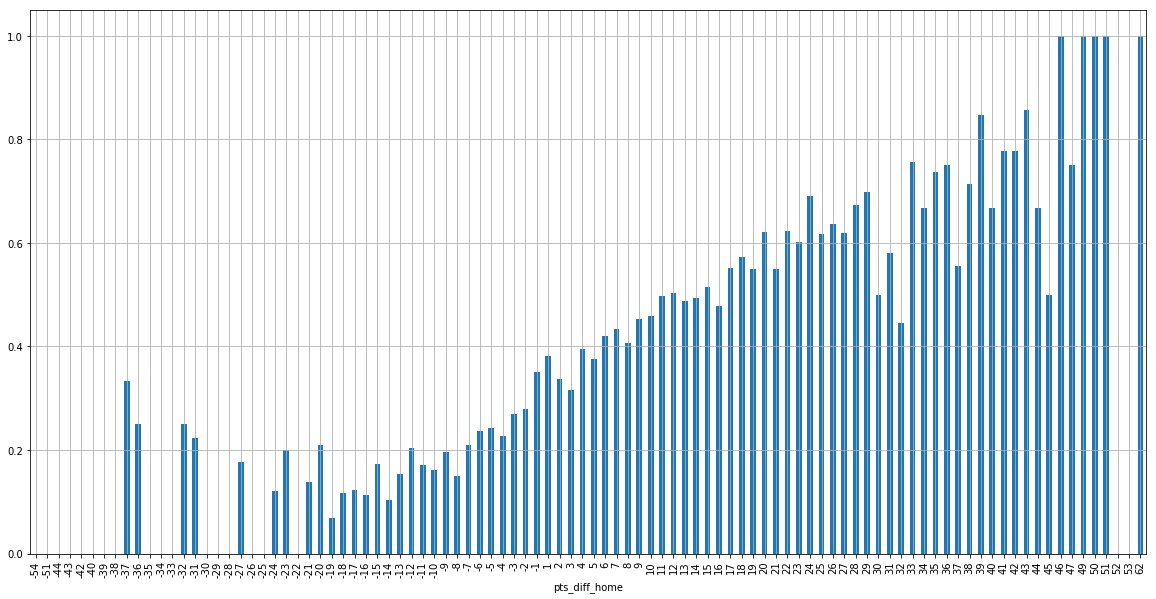

In [7]:
df_mean.plot(kind='bar', figsize = (20, 10), grid=True, legend=False)
plt.show()

In [8]:
X = data["pts_diff_home"].values.reshape(-1, 1)
y = data["W"].values.ravel()

y = y.astype('int')

In [9]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)

In [10]:
a = clf.coef_[0][0]
b = clf.intercept_[0]
print(a, b)

0.028514775769103322 -0.40862229257236893


In [11]:
def model(x, a, b):
    x = x * a + b
    return 1 / (1 + np.exp(-x))

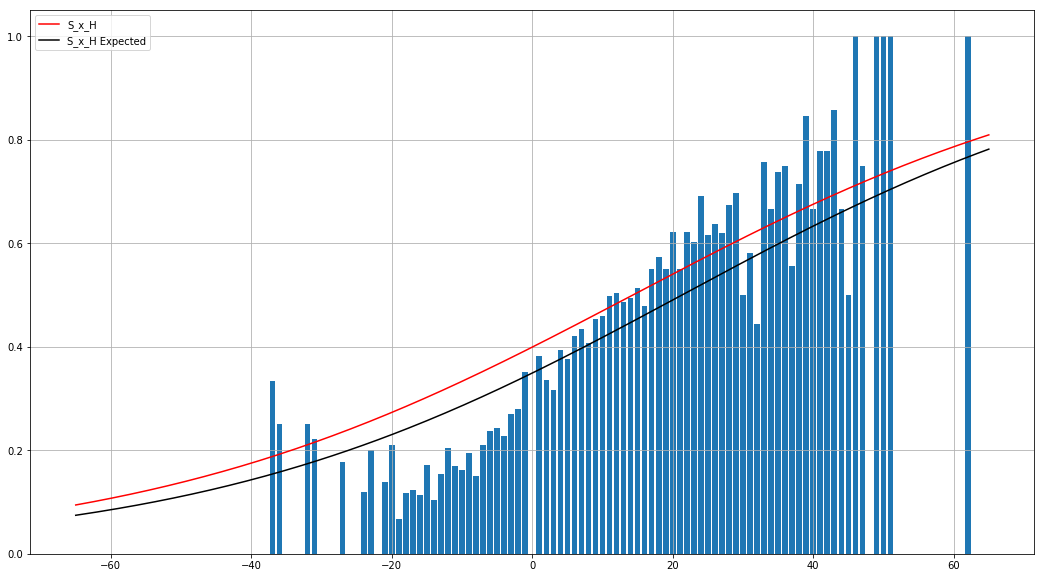

In [12]:
plt.figure(figsize=(18, 10))

X_test = np.linspace(-65, 65, 300)

S_x_H = model(X_test, a , b).ravel()
S_x_H_expected = model(X_test, 0.0292, -0.6228).ravel()

plt.plot(X_test, S_x_H, color='red', label='S_x_H')
plt.plot(X_test, S_x_H_expected, color='black',  label='S_x_H Expected')
plt.bar(df_mean.index, df_mean["W"])

plt.legend()
plt.grid()

plt.show()

In [13]:
+ 0.6228 / 0.0292

21.328767123287673

In [14]:
x = - a / b
x

0.06978272181284192

In [15]:
model(x, a, b)

0.39971986974090223

In [16]:
h = x / 2

In [17]:
def r_x_H(x, a, b):
    h = (- b / a) / 2
    x += h
    x = x * a + b
    return 1 / (1 + np.exp(-x))

In [18]:
def r_x_R(x, a, b):
    return 1 - r_x_H(x, a, b)

In [19]:
import sqlite3

import pandas as pd

from config import Config

In [ ]:
year = 2018

conn = sqlite3.connect(Config.DB_PATH)
c = conn.cursor()

sql = f"SELECT DISTINCT Team_1 FROM Scores WHERE Season = {year} ORDER BY Team_1"

c.execute(sql)

teams = c.fetchall()

teams = [i[0] for i in teams]

transition_matrix = pd.DataFrame(data = None, index=teams, columns=teams)

In [ ]:
for i in range(len(teams)):
    team_i = teams[i]
        
    c.execute("SELECT Team_1, Team_2, Team_1_points, Team_2_points From Scores Where Season = ? AND " \
              "(Team_1 = ? OR Team_2 = ?) AND Neutral = 0 AND Type = 'REG'", (year, team_i, team_i))
        
    r = c.fetchall()
    
    schedule = pd.DataFrame(data=r, columns=['Team_1', 'Team_2', 'Team_1_points', 'Team_2_points'])
    
    N = schedule.shape[0]
    for j in range(len(teams)):
        if i != j:
            t_i_j = 0
            
            team_j = teams[j]
            
            mask = (schedule['Team_1'] == team_j) | (schedule['Team_2'] == team_j)
            games = schedule[mask]
            
            for index, row in games.iterrows():
                pts_diff = row['Team_1_points'] - row['Team_2_points']
                
                t_i_j += (1 - r_x_R(pts_diff, a, b)) + (1 - r_x_H(pts_diff, a , b))
                
            t_i_j /= N
            transition_matrix.loc[team_i, team_j] = t_i_j
        
        else:
            t_i_i = 0
            
            for index, row in schedule.iterrows():
                pts_diff = row['Team_1_points'] - row['Team_2_points']
                
                t_i_i = r_x_R(pts_diff, a, b) + r_x_H(pts_diff, a, b)
            
            t_i_i /= N
            transition_matrix.loc[team_i, team_i] = t_i_i
                

In [ ]:
transition_matrix

In [ ]:
def steady_state_prob(p):
    '''

    :param p: transition matrix
    :return: steady state probability matrix
    '''
    dim = p.shape[0]
    q = (p - np.eye(dim))
    ones = np.ones(dim)
    q = np.c_[q, ones]
    QTQ = np.dot(q, q.T)
    bQT = np.ones(dim)
    return np.linalg.solve(QTQ, bQT)

In [ ]:
score = steady_state_prob(transition_matrix.astype(np.float).values)

In [ ]:
df_score = pd.DataFrame(data = score, index = teams, columns = ['ranking'])

In [ ]:
df_score.sort('ranking', ascending= False)